<a href="https://colab.research.google.com/github/aiyazsarwar/Amazon-Fine-Food-Reviews/blob/master/05_Amazon_Fine_Food_Reviews_Analysis_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/gdrive/My Drive/Amazon reviews data set/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Sorting data according to Time in ascending order
sorted_data=sorted_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
sorted_data[:10]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan..."
77066,83844,B0000SY9UE,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan..."
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to..."
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...


In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape   

(87775, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73591
0    14182
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!<br /><br />(For those wo

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!(For those wondering, this mix requ

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love Pretzels and have to say that after trying my way through many different kinds, these are The BEST.<br /><br />The taste great, are REALLY crunchy - a key requirement for me - and have just the right amount of salt. The Newman is Rounds are just as good - maybe even better.<br /><br />And as an added bonus, Paul Newmann donates all his after tax profits from the sale of his products to charity - an unbeatable combination in my book!


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love Pretzels and have to say that after trying my way through many different kinds these are The BEST br br The taste great are REALLY crunchy a key requirement for me and have just the right amount of salt The Newman is Rounds are just as good maybe even better br br And as an added bonus Paul Newmann donates all his after tax profits from the sale of his products to charity an unbeatable combination in my book 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2552.00it/s]


In [26]:
preprocessed_reviews[1500]

'love pretzels say trying way many different kinds best taste great really crunchy key requirement right amount salt newman rounds good maybe even better added bonus paul newmann donates tax profits sale products charity unbeatable combination book'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 87773/87773 [00:22<00:00, 3917.14it/s]


# Splitting data into train and test set

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(preprocessed_reviews,final['Score'],random_state=100,test_size=0.30,shuffle=False)

X_train2,X_CV,y_train2,y_CV = train_test_split(X_train,y_train,random_state=100,test_size=0.30,shuffle=False)

# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train2)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
features_bow = count_vect.get_feature_names()
final_counts = count_vect.transform(X_train2)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

final_countsCV = count_vect.transform(X_CV)
final_countsTEST = count_vect.transform(X_test)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaarrrrrggghhh', 'aaaaah', 'aaaah', 'aaaand', 'aachen', 'aadp']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 38757)
the number of unique words  38757


## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect2 = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect2.fit(X_train2)
print("some feature names ", count_vect2.get_feature_names()[:10])
print('='*50)

final_bigram_counts = count_vect2.transform(X_train2)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

final_bigram_countsCV = count_vect2.transform(X_CV)
final_bigram_countsTEST = count_vect2.transform(X_test)

some feature names  ['ability', 'able', 'able buy', 'able find', 'able get', 'able order', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train2)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

features_tf_idf = tf_idf_vect.get_feature_names()

final_tf_idf = tf_idf_vect.transform(X_train2)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

final_tf_idfCV = tf_idf_vect.transform(X_CV)
final_tf_idfTEST = tf_idf_vect.transform(X_test)

some sample features(unique words in the corpus) ['abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able figure']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (43008, 25453)
the number of unique words including both unigrams and bigrams  25453


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence_train=[]
for sentence in X_train2:
    list_of_sentence_train.append(sentence.split())

In [33]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sentence_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12484
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#  Converting Train data text

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 43008/43008 [01:14<00:00, 573.78it/s]


(43008, 50)
[-0.20669276  0.58916399 -0.11469726  0.1109095  -0.05957806  0.10982644
 -0.08652993  0.0399588  -0.08315238 -0.33251048  0.1319007  -0.54469424
  0.24005166 -0.49732831  0.12074231  0.2663154   0.40095035 -0.00448499
  0.38545787  0.57174001  0.32999158 -0.35981038 -0.27199241  0.11904008
  0.03059834  0.39790983  0.32744904 -0.11924028 -0.23483223  0.45556083
 -0.09304533 -0.37392897  0.33075289  0.29298652 -0.7793197   0.06745431
  0.29497722  0.42512537  0.32820056 -0.0345826   0.17788553  0.28533132
 -0.19980676 -0.08164008 -0.39693502 -0.04115105 -0.28005516  0.62978337
 -0.01710902  0.17623093]


# ### Converting CV data text

In [35]:
i=0
list_of_sentence_cv=[]
for sentence in X_CV:
    list_of_sentence_cv.append(sentence.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 18433/18433 [00:33<00:00, 543.15it/s]

(18433, 50)
[ 0.19221394  0.54930799  0.65441068 -0.39384748 -1.51399332 -0.14951641
  0.70102653  0.50357174  0.21002457 -0.21683838  0.41153982 -0.80419879
  0.20480991 -0.91449189  0.73327948  0.52658758  0.68843109 -0.3705822
  1.70963038  0.16205138  0.73992799 -0.00548289 -0.59839128 -0.42184987
 -0.56659937 -0.01804079  0.99513273  0.70575043  0.00317727 -0.2071196
 -0.49296724  0.00178677 -0.25597909 -0.30077035 -0.12525961 -0.6887949
  0.92628943  0.55367268 -0.17519292  0.35644618 -0.91485965 -0.07393792
  0.44128274 -0.32410102  0.86501637 -0.47477216  0.10014595  0.44906412
 -0.300466   -0.37744389]


# Converting Test data text

In [36]:
i=0
list_of_sentence_test=[]
for sentence in X_test:
    list_of_sentence_test.append(sentence.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 26332/26332 [00:48<00:00, 539.99it/s]

(26332, 50)
[ 0.1810509   0.52466841 -0.16050331 -0.22598343 -0.24575987  0.25827636
 -0.08188385  0.09919999  0.21543728 -0.32095605  0.56739069 -0.46450456
  0.41986997 -0.47424161  0.03135908  0.33251949  0.64295036  0.39475039
  0.84644837  0.57304966  0.59594499 -0.67009347  0.14250165  0.45298655
 -0.11480141  0.58342565  0.42627308  0.22673422 -0.03471594 -0.0432431
 -0.17933605 -0.36277284  0.61138621  0.26529314 -0.63440522 -0.27990661
  0.12806524  0.21393468  0.26524139  0.13753112  0.08736701  0.23594476
 -0.31135401 -0.25424942 -0.26882972  0.29055052 -0.26700754  0.57805238
  0.10821426  0.07791255]


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_tf = TfidfVectorizer()
tf_idf_matrix = model_tf.fit_transform(X_train2)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_tf.get_feature_names(), list(model_tf.idf_)))

# Calculating TFIDF weighted W2V for training data

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_tf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 43008/43008 [13:02<00:00, 54.99it/s]


# # Calculating TFIDF weighted W2V for CV data

In [39]:

tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

100%|██████████| 18433/18433 [05:43<00:00, 56.70it/s]


# Calculating TFIDF weighted W2V for test data

In [40]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [08:22<00:00, 52.41it/s]


In [0]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
tfidf_sent_vectors_CV = np.array(tfidf_sent_vectors_CV)
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [43]:
# Please write all the code with proper documentation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')

clf_LR_L1 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=5,random_state=100,return_train_score=True)
clf_LR_L1.fit(final_counts,y_train2)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l1', random_state=None,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.01, 1, 100, 10000]},
                   pre_dispatch='2*n_jobs', random_state=100, refit=True,
                   return_train_score=True, scoring='roc_auc', verbose=0)

In [44]:
clf_LR_L1.cv_results_['mean_train_score']

array([0.5       , 0.87712519, 0.99341006, 0.99999677, 0.99999714])

In [45]:
AUC_bow_train = clf_LR_L1.cv_results_['mean_train_score']
best_auc_score_bow_l1 = clf_LR_L1.best_score_
optimal_C_bow_l1 = clf_LR_L1.best_params_['C']

print('best_auc_score_bow_l1 ',best_auc_score_bow_l1)
print('optimal_C_bow_l1 ',optimal_C_bow_l1)

best_auc_score_bow_l1  0.919703726203928
optimal_C_bow_l1  1


In [46]:
clf_LR_L1.cv_results_['params']

[{'C': 0.0001}, {'C': 0.01}, {'C': 1}, {'C': 100}, {'C': 10000}]

In [0]:
#[i['C'] for i in clf_LR_L1.cv_results_['params']]

In [0]:
#finding auc scores for our CV data for validation
AUC_bow_CV_l1 = clf_LR_L1.cv_results_['mean_test_score']
    

Text(0, 0.5, 'AUC values')

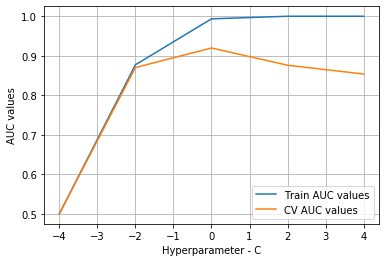

In [49]:
#plotting ROC curve for train and CV data
plt.plot(np.log10(hyperparameters['C']),AUC_bow_train,label='Train AUC values')
plt.plot(np.log10(hyperparameters['C']),AUC_bow_CV_l1,label='CV AUC values')
plt.legend()
plt.grid()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

In [0]:
#As we have selected our best parameter,so finding auc scores for our test data to shown the results

model_lr_l1 = LogisticRegression(C=optimal_C_bow_l1 ,class_weight='balanced',penalty='l1',solver='liblinear').fit(final_counts,y_train2)

y_train_pred_prob = model_lr_l1.predict_proba(final_counts)[:,1]
fpr1,tpr1,t1 = metrics.roc_curve(y_train2,y_train_pred_prob)

y_test_pred_prob = model_lr_l1.predict_proba(final_countsTEST)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test,y_test_pred_prob)

Text(0, 0.5, 'True Positive Rate')

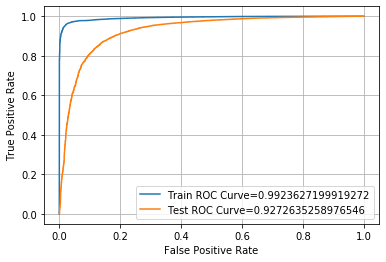

In [52]:
#plotting ROC curve for train and test data
plt.plot(fpr1,tpr1,label='Train ROC Curve=' +str(metrics.auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


In [0]:
def find_best_threshold(thresh, fpr, tpr):
    t = thresh[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, thresh):
    predictions = []
    for i in proba:
        if i>=thresh:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.9378685409656237 for threshold 0.428
*********Train confusion matrix*********
[[ 6200   160]
 [ 1390 35258]]


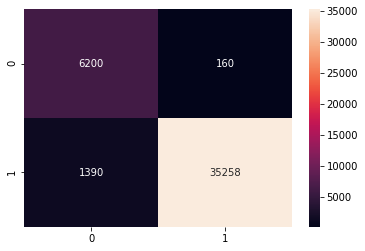

In [54]:
best_t = find_best_threshold(t1,fpr1,tpr1)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_train_pred_prob, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_train_pred_prob, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 3529  1027]
 [ 1665 20111]]


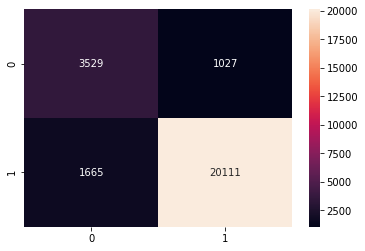

In [55]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_prob, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred_prob, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [56]:
# Please write all the code with proper documentation
#using already trained model

coef_bow_l1 = model_lr_l1.coef_.ravel()
sparsity_bow_l1 = np.mean(coef_bow_l1 == 0) * 100

print(sparsity_bow_l1)
print(np.count_nonzero(model_lr_l1.coef_))

89.14776685501974
4206


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

AUC score for Logistic Regression Model with L2 regularization  [0.82924336 0.95497765 0.99603677 0.99936396 0.99945627]
best_auc_score_bow_l2  0.9261930805224466
optimal_C_bow_l2  0.01


Text(0, 0.5, 'AUC values')

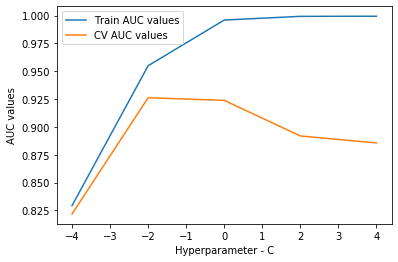

In [57]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l2',class_weight='balanced')

clf_LR_l2 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100,return_train_score=True)
clf_LR_l2.fit(final_counts,y_train2)

print('AUC score for Logistic Regression Model with L2 regularization ',clf_LR_l2.cv_results_['mean_train_score'])

AUC_bow_train_l2 = clf_LR_l2.cv_results_['mean_train_score']
best_auc_score_bow_l2 = clf_LR_l2.best_score_
optimal_C_bow_l2 = clf_LR_l2.best_params_['C']

print('best_auc_score_bow_l2 ',best_auc_score_bow_l2)
print('optimal_C_bow_l2 ',optimal_C_bow_l2)

#finding auc scores for our CV data for validation
AUC_bow_CV_l2 = clf_LR_l2.cv_results_['mean_test_score']

#plotting ROC curve for train and CV data
plt.plot(np.log10(hyperparameters['C']),AUC_bow_train_l2,label='Train AUC values')
plt.plot(np.log10(hyperparameters['C']),AUC_bow_CV_l2,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  



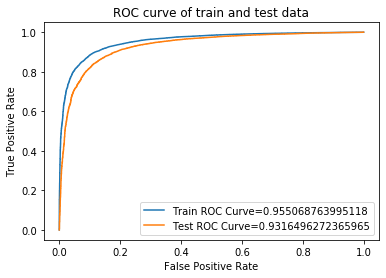

In [58]:
model_l2 = LogisticRegression(penalty='l2',C=optimal_C_bow_l2,class_weight='balanced')
model_l2 = model_l2.fit(final_counts,y_train2)

y_pred_l2 = model_l2.predict_proba(final_counts)[:,1]
fpr1,tpr1,t1 = metrics.roc_curve(y_train2,y_pred_l2)

y_pred_l22 = model_l2.predict_proba(final_countsTEST)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test,y_pred_l22)

plt.plot(fpr1,tpr1,label='Train ROC Curve=' +str(metrics.auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.7963381014554236 for threshold 0.494
*********Train confusion matrix*********
[[ 5702   658]
 [ 4096 32552]]


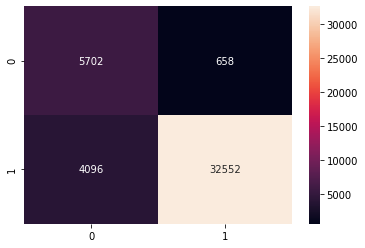

In [59]:
best_t_bow_l2 = find_best_threshold(t1,fpr1,tpr1)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_l2, best_t_bow_l2)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_l2, best_t_bow_l2))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 3901   655]
 [ 2810 18966]]


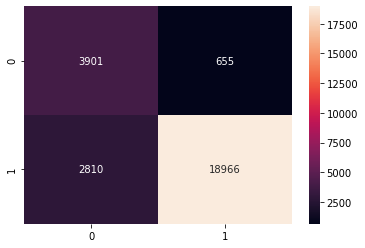

In [60]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_l22, best_t_bow_l2)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_l22, best_t_bow_l2))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

In [61]:
#Calculating sparsity on weight vector obtained using L2 regularization on BOW
#using already trained model

coef_bow_l2 = model_l2.coef_.ravel()
sparsity_bow_l2 = np.mean(coef_bow_l2 == 0) * 100

print('sparsity_bow_l2 ',sparsity_bow_l2)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(model_l2.coef_))

sparsity_bow_l2  0.0
Number of non zero entries which indicates sparsity  38757


OBSERVATION : We see that using l2 penalty the sparsity gets reduced dramatically as compared to l1

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [62]:
# Please write all the code with proper documentation
coef_before_l2 = model_l2.coef_

#generating and adding small noise to the data and calculating weights again

e = np.random.normal(loc=0,scale=0.000001,size=final_counts.data.shape)
X_noisy_l2 = final_counts
X_noisy_l2.data = final_counts.data + e

print(X_noisy_l2.shape)

(43008, 38757)


In [0]:
#Introducing noisy data to our model
noisy_model_bow_l2 = LogisticRegression(penalty='l2',C=optimal_C_bow_l2,class_weight='balanced')
noisy_model_bow_l2.fit(X_noisy_l2,y_train2)

#getting new weights

coef_after_l2 = noisy_model_bow_l2.coef_

In [0]:
#to eliminate divisible by zero error,adding 10^-6 to coef_before_l2 and coef_after_l2
coef_before_l2 += 10**-6
coef_after_l2 += 10**-6
change_vec_l2 = []

#Calculating the percentage change in weights
for i in range(coef_before_l2.shape[1]):
    w = ((coef_after_l2[0][i] - coef_before_l2[0][i])/(coef_before_l2[0][i]))
    change_vec_l2.append(w)
    

In [65]:
#Sorting to get the quantiles
change_vec_l2_ = sorted(change_vec_l2,reverse=True)

for i in range(11):
    print(str(i*10) + 'th percentile value is ' + str(np.quantile(change_vec_l2_,i*0.1)))

0th percentile value is -0.004379175649395512
10th percentile value is -3.2794036906679345e-06
20th percentile value is -1.5141264379636856e-06
30th percentile value is -8.097359736167566e-07
40th percentile value is -3.6667256951606164e-07
50th percentile value is -2.878661332265939e-08
60th percentile value is 2.847919982082891e-07
70th percentile value is 6.39381201945484e-07
80th percentile value is 1.0959241236194103e-06
90th percentile value is 1.8286153745279417e-06
100th percentile value is 0.008164609801692613


In [66]:
for i in range(90,101):
    print(str(i)+'th percentile = '+str(np.percentile(change_vec_l2_,i)))

90th percentile = 1.8286153745279417e-06
91th percentile = 1.9550809446019326e-06
92th percentile = 2.081666332246727e-06
93th percentile = 2.2565782562130957e-06
94th percentile = 2.4633873372811617e-06
95th percentile = 2.705933217481079e-06
96th percentile = 3.061296675341813e-06
97th percentile = 3.5737765833378694e-06
98th percentile = 4.639226638362697e-06
99th percentile = 8.814000022902006e-06
100th percentile = 0.008164609801692613


In [67]:
for i in np.linspace(99,100,11):
    print(str(i)+'th percentile = '+str(np.percentile(change_vec_l2_,i)))

99.0th percentile = 8.814000022902006e-06
99.1th percentile = 1.0098558284563463e-05
99.2th percentile = 1.1369836897526364e-05
99.3th percentile = 1.349697289922318e-05
99.4th percentile = 1.583409812159496e-05
99.5th percentile = 2.0103094649144117e-05
99.6th percentile = 2.5935516061470587e-05
99.7th percentile = 3.4084983752137966e-05
99.8th percentile = 5.485173252826599e-05
99.9th percentile = 0.00019399290130429225
100.0th percentile = 0.008164609801692613


In [68]:
for i in np.linspace(99.9,100,11):
    print(str(i)+'th percentile = '+str(np.percentile(change_vec_l2_,i)))

99.9th percentile = 0.00019399290130429225
99.91000000000001th percentile = 0.00023914879939485964
99.92th percentile = 0.0002874148526526067
99.93th percentile = 0.00039675663286166055
99.94th percentile = 0.0005971778423523322
99.95th percentile = 0.0010515512159889136
99.96000000000001th percentile = 0.0010523450117813238
99.97th percentile = 0.0015754755333721253
99.98th percentile = 0.002271487832570572
99.99th percentile = 0.0036030708557768737
100.0th percentile = 0.008164609801692613


In [69]:
change_vec_l2 = np.absolute(change_vec_l2).tolist()
change_vec_l2_ = np.absolute(change_vec_l2_)
j=[]
for i in np.linspace(99.9,100,11):
    print(i)
    j.append(np.percentile(change_vec_l2_,i))
    #j = change_vec_l2.index(np.percentile(change_vec_l2_,i))
    #print(j)
    #print(features_bow[j])

99.9
99.91000000000001
99.92
99.93
99.94
99.95
99.96000000000001
99.97
99.98
99.99
100.0


In [0]:
#finding the features whose difference is more than 2.5
j=[i for i in change_vec_l2 if i > 2.5]

for k in j:
    print(features_bow[change_vec_l2.index(k)])

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [71]:
# Please write all the code with proper documentation
#finding the index of positive features

i_pos = np.argsort(coef_before_l2)[:,::-1]

for i in i_pos[0][0:10]:
    print(features_bow[i])

delicious
best
great
perfect
excellent
loves
wonderful
easy
highly
nice


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [72]:
# Please write all the code with proper documentation
i_neg = np.argsort(coef_before_l2)

for i in i_neg[0][0:10]:
    print(features_bow[i])


disappointed
worst
unfortunately
awful
horrible
money
terrible
disappointing
waste
stale


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

AUC score for Logistic Regression Model with TFIDF features and l1 regularization  [0.5        0.68579571 0.97685537 0.99999714 0.99999714]
best_auc_score_tfidf_l1  0.948897972639003
optimal_C_tfidf_l1  1


Text(0, 0.5, 'AUC values')

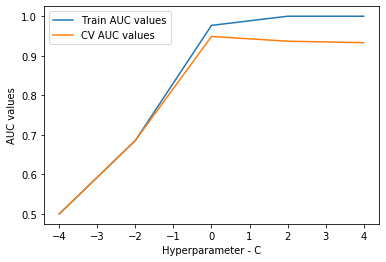

In [73]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')

clf_tfidf_l1 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=5,random_state=100,return_train_score=True)
clf_tfidf_l1.fit(final_tf_idf,y_train2)

print('AUC score for Logistic Regression Model with TFIDF features and l1 regularization ',clf_tfidf_l1.cv_results_['mean_train_score'])

AUC_tfidf_train_l1 = clf_tfidf_l1.cv_results_['mean_train_score']
best_auc_score_tfidf_l1 = clf_tfidf_l1.best_score_
optimal_C_tfidf_l1 = clf_tfidf_l1.best_params_['C']

print('best_auc_score_tfidf_l1 ',best_auc_score_tfidf_l1)
print('optimal_C_tfidf_l1 ',optimal_C_tfidf_l1)

#finding auc scores for our CV data for validation
AUC_tfidf_CV_l1 = clf_tfidf_l1.cv_results_['mean_test_score']
    

#plotting ROC curve for train and CV data
plt.plot(np.log10(hyperparameters['C']),AUC_tfidf_train_l1,label='Train AUC values')
plt.plot(np.log10(hyperparameters['C']),AUC_tfidf_CV_l1,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

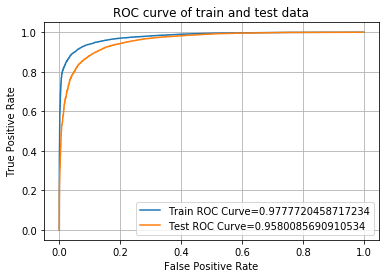

In [74]:
#Plotting ROC curve as FPR vs TPR

model_roc_l1 = LogisticRegression(penalty='l1',solver='liblinear',C=optimal_C_tfidf_l1,class_weight='balanced')
model_roc_l1 = model_roc_l1.fit(final_tf_idf,y_train2)

y_pred_train_l1 = model_roc_l1.predict_proba(final_tf_idf)[:,1]
fpr1,tpr1,t1 = metrics.roc_curve(y_train2,y_pred_train_l1)

y_pred_test_l1 = model_roc_l1.predict_proba(final_tf_idfTEST)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test,y_pred_test_l1)

plt.plot(fpr1,tpr1,label='Train ROC Curve=' +str(metrics.auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.8579915770155373 for threshold 0.516
*********Train confusion matrix*********
[[ 5983   377]
 [ 3223 33425]]


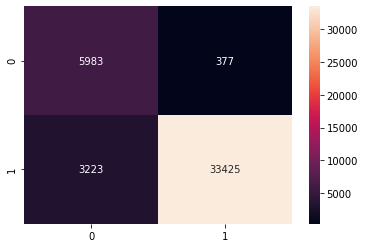

In [75]:
best_t_tfidf_l1 = find_best_threshold(t1,fpr1,tpr1)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l1, best_t_tfidf_l1)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l1, best_t_tfidf_l1))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 4037   519]
 [ 2283 19493]]


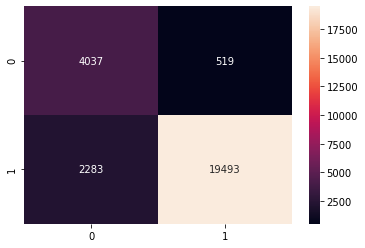

In [76]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_test_l1, best_t_tfidf_l1)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_test_l1, best_t_tfidf_l1))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

In [77]:
##Calculating sparsity on weight vector obtained using L1 regularization on TFIDF
#using already trained model

coef_tfidf_l1 = model_roc_l1.coef_.ravel()
sparsity_tfidf_l1 = np.mean(coef_tfidf_l1 == 0) * 100

print('sparsity_tfidf_l1 ',sparsity_tfidf_l1)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(model_roc_l1.coef_))

sparsity_tfidf_l1  93.2267316229914
Number of non zero entries which indicates sparsity  1724


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

AUC score for Logistic Regression Model with TFIDF features and l2 regularization  [0.91266987 0.92419852 0.98815968 0.99995932 0.99999717]
best_auc_score_tfidf_l2  0.9558950377524006
optimal_C_tfidf_l2  1


Text(0, 0.5, 'AUC values')

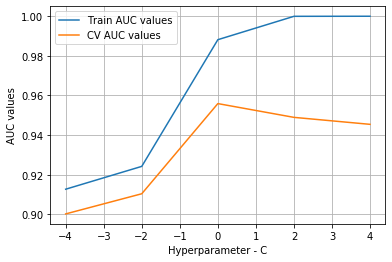

In [78]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l2',class_weight='balanced')

clf_tfidf_l2 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100,return_train_score=True)
clf_tfidf_l2.fit(final_tf_idf,y_train2)

print('AUC score for Logistic Regression Model with TFIDF features and l2 regularization ',clf_tfidf_l2.cv_results_['mean_train_score'])

AUC_tfidf_train_l2 = clf_tfidf_l2.cv_results_['mean_train_score']
best_auc_score_tfidf_l2 = clf_tfidf_l2.best_score_
optimal_C_tfidf_l2 = clf_tfidf_l2.best_params_['C']

print('best_auc_score_tfidf_l2 ',best_auc_score_tfidf_l2)
print('optimal_C_tfidf_l2 ',optimal_C_tfidf_l2)

#finding auc scores for our CV data for validation
AUC_tfidf_CV_l2 = clf_tfidf_l2.cv_results_['mean_test_score']


#plotting ROC curve for train and CV data
plt.plot(np.log10(hyperparameters['C']),AUC_tfidf_train_l2,label='Train AUC values')
plt.plot(np.log10(hyperparameters['C']),AUC_tfidf_CV_l2,label='CV AUC values')
plt.legend()
plt.grid()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  



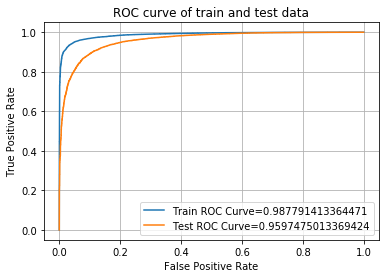

In [79]:
#Plotting ROC curve as FPR vs TPR

model_roc_l2 = LogisticRegression(penalty='l2',C=optimal_C_tfidf_l2,class_weight='balanced')
model_roc_l2 = model_roc_l2.fit(final_tf_idf,y_train2)

y_pred_train_l2 = model_roc_l2.predict_proba(final_tf_idf)[:,1]
fpr1,tpr1,t1 = metrics.roc_curve(y_train2,y_pred_train_l2)

y_pred_test_l2 = model_roc_l2.predict_proba(final_tf_idfTEST)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test,y_pred_test_l2)

plt.plot(fpr1,tpr1,label='Train ROC Curve=' +str(metrics.auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()


the maximum value of tpr*(1-fpr) 0.9043416099310935 for threshold 0.5
*********Train confusion matrix*********
[[ 6150   210]
 [ 2374 34274]]


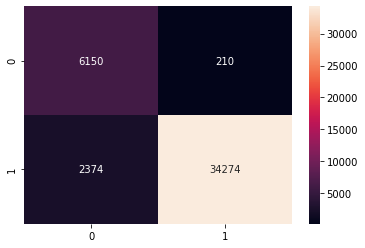

In [80]:
best_t_tfidf_l2 = find_best_threshold(t1,fpr1,tpr1)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l2, best_t_tfidf_l2)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l2, best_t_tfidf_l2))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 3975   581]
 [ 1902 19874]]


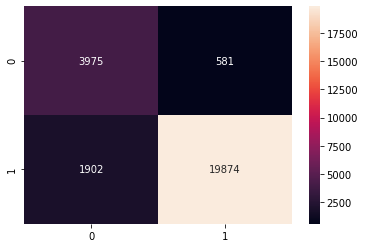

In [81]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_test_l2, best_t_tfidf_l2)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_test_l2, best_t_tfidf_l2))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

In [82]:
##Calculating sparsity on weight vector obtained using L1 regularization on TFIDF
#using already trained model

coef_tfidf_l2 = model_roc_l2.coef_.ravel()
sparsity_tfidf_l2 = np.mean(coef_tfidf_l2 == 0) * 100

print('sparsity_tfidf_l2 ',sparsity_tfidf_l2)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(model_roc_l2.coef_))

sparsity_tfidf_l2  0.0
Number of non zero entries which indicates sparsity  25453


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [83]:
coef_tf = model_roc_l2.coef_
i_pos2 = np.argsort(coef_tf)[:,::-1]

for i in i_pos2[0][0:10]:
    print(features_tf_idf[i])

great
delicious
best
good
perfect
love
loves
excellent
wonderful
nice


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [84]:
# Please write all the code with proper documentation
i_neg2 = np.argsort(coef_tf)

for i in i_neg2[0][0:10]:
    print(features_tf_idf[i])

not
disappointed
worst
terrible
awful
not worth
disappointing
unfortunately
not good
horrible


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

AUC score for Logistic Regression Model with Avg W2V features and l1 regularization  [0.5        0.89319112 0.89689027 0.89688846 0.89688804]
best_auc_score_avgw2v_l1  0.8940469734684754
optimal_C_avgw2v_l1  1


Text(0, 0.5, 'AUC values')

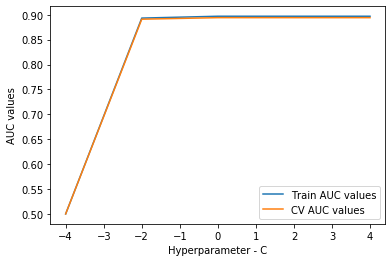

In [85]:
# Please write all the code with proper documentation


hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')

clf_avgw2v_l1 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=5,random_state=100,return_train_score=True)
clf_avgw2v_l1.fit(sent_vectors_train,y_train2)

print('AUC score for Logistic Regression Model with Avg W2V features and l1 regularization ',clf_avgw2v_l1.cv_results_['mean_train_score'])

AUC_avgw2v_train_l1 = clf_avgw2v_l1.cv_results_['mean_train_score']
best_auc_score_avgw2v_l1 = clf_avgw2v_l1.best_score_
optimal_C_avgw2v_l1 = clf_avgw2v_l1.best_params_['C']

print('best_auc_score_avgw2v_l1 ',best_auc_score_avgw2v_l1)
print('optimal_C_avgw2v_l1 ',optimal_C_avgw2v_l1)

#finding auc scores for our CV data for validation
AUC_avgw2v_CV_l1 = clf_avgw2v_l1.cv_results_['mean_test_score']
    

#plotting ROC curve for train and CV data
plt.plot(np.log10(hyperparameters['C']),AUC_avgw2v_train_l1,label='Train AUC values')
plt.plot(np.log10(hyperparameters['C']),AUC_avgw2v_CV_l1,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

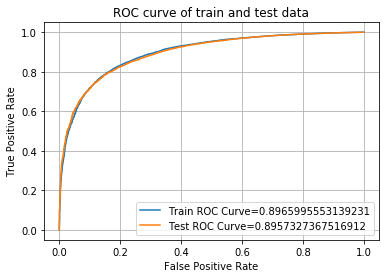

In [86]:
#Plotting ROC curve as FPR vs TPR

model_roc_l1 = LogisticRegression(penalty='l1',solver='liblinear',C=optimal_C_avgw2v_l1,class_weight='balanced')
model_roc_l1 = model_roc_l1.fit(sent_vectors_train,y_train2)

y_pred_train_l1 = model_roc_l1.predict_proba(sent_vectors_train)[:,1]
fpr1,tpr1,t1 = metrics.roc_curve(y_train2,y_pred_train_l1)

y_pred_test_l1 = model_roc_l1.predict_proba(sent_vectors_test)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test,y_pred_test_l1)

plt.plot(fpr1,tpr1,label='Train ROC Curve=' +str(metrics.auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.6712364888334232 for threshold 0.506
*********Train confusion matrix*********
[[ 5369   991]
 [ 7508 29140]]


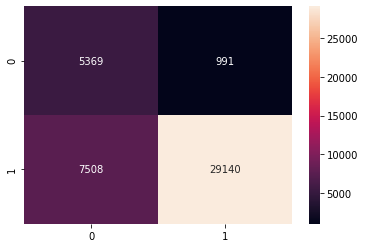

In [87]:
best_t_avgw2v_l1 = find_best_threshold(t1,fpr1,tpr1)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l1, best_t_avgw2v_l1)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l1, best_t_avgw2v_l1))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 3902   654]
 [ 4856 16920]]


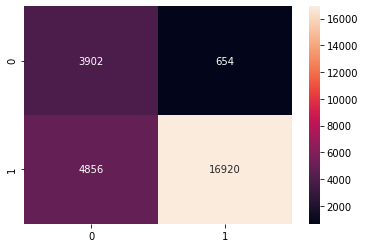

In [88]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_test_l1, best_t_avgw2v_l1)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_test_l1, best_t_avgw2v_l1))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

In [89]:
##Calculating sparsity on weight vector obtained using L1 regularization on AVG W2V
#using already trained model

coef_avgw2v_l1 = model_roc_l1.coef_.ravel()
sparsity_avgw2v_l1 = np.mean(coef_avgw2v_l1 == 0) * 100

print('sparsity_avgw2v_l1 ',sparsity_avgw2v_l1)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(model_roc_l1.coef_))

sparsity_avgw2v_l1  0.0
Number of non zero entries which indicates sparsity  50


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

AUC score for Logistic Regression Model with Avg W2V features and l2 regularization  [0.88222018 0.89574177 0.89670529 0.89670462 0.89670494]
best_auc_score_avgw2v_l1  0.8944570785532276
optimal_C_avgw2v_l1  1


Text(0, 0.5, 'AUC values')

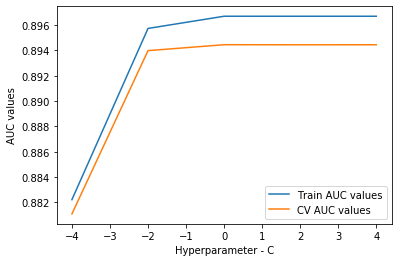

In [90]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l2',class_weight='balanced')

clf_avgw2v_l2 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100,return_train_score=True)
clf_avgw2v_l2.fit(sent_vectors_train,y_train2)

print('AUC score for Logistic Regression Model with Avg W2V features and l2 regularization ',clf_avgw2v_l2.cv_results_['mean_train_score'])

AUC_avgw2v_train_l2 = clf_avgw2v_l2.cv_results_['mean_train_score']
best_auc_score_avgw2v_l2 = clf_avgw2v_l2.best_score_
optimal_C_avgw2v_l2 = clf_avgw2v_l2.best_params_['C']

print('best_auc_score_avgw2v_l1 ',best_auc_score_avgw2v_l2)
print('optimal_C_avgw2v_l1 ',optimal_C_avgw2v_l2)

#finding auc scores for our CV data for validation
AUC_avgw2v_CV_l2 = clf_avgw2v_l2.cv_results_['mean_test_score']
    

#plotting ROC curve for train and CV data
plt.plot(np.log10(hyperparameters['C']),AUC_avgw2v_train_l2,label='Train AUC values')
plt.plot(np.log10(hyperparameters['C']),AUC_avgw2v_CV_l2,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

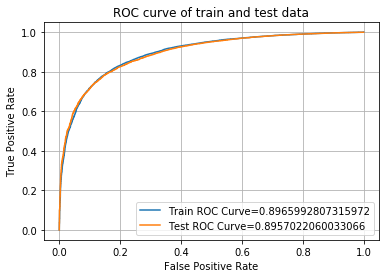

In [91]:
#Plotting ROC curve as FPR vs TPR

model_roc_l2 = LogisticRegression(penalty='l2',C=optimal_C_avgw2v_l2,class_weight='balanced')
model_roc_l2 = model_roc_l2.fit(sent_vectors_train,y_train2)

y_pred_train_l2 = model_roc_l2.predict_proba(sent_vectors_train)[:,1]
fpr1,tpr1,t1 = metrics.roc_curve(y_train2,y_pred_train_l2)

y_pred_test_l2 = model_roc_l2.predict_proba(sent_vectors_test)[:,1]
fpr2,tpr2,t = metrics.roc_curve(y_test,y_pred_test_l2)

plt.plot(fpr1,tpr1,label='Train ROC Curve=' +str(metrics.auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()



the maximum value of tpr*(1-fpr) 0.6712364888334232 for threshold 0.506
*********Train confusion matrix*********
[[ 5369   991]
 [ 7508 29140]]


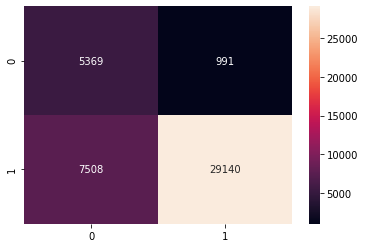

In [92]:
best_t_avgw2v_l2 = find_best_threshold(t1,fpr1,tpr1)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l2, best_t_avgw2v_l2)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l2, best_t_avgw2v_l2))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 3902   654]
 [ 4859 16917]]


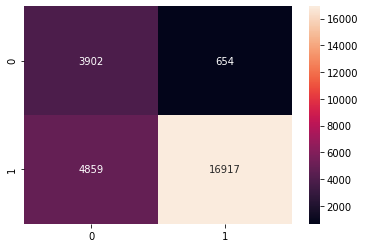

In [93]:

print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_test_l2, best_t_avgw2v_l2)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_test_l2, best_t_avgw2v_l2))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

In [94]:
##Calculating sparsity on weight vector obtained using L1 regularization on AVG W2V
#using already trained model

coef_avgw2v_l2 = model_roc_l2.coef_.ravel()
sparsity_avgw2v_l2 = np.mean(coef_avgw2v_l2 == 0) * 100

print('sparsity_avgw2v_l2 ',sparsity_avgw2v_l2)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(model_roc_l2.coef_))

sparsity_avgw2v_l2  0.0
Number of non zero entries which indicates sparsity  50


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

AUC score for Logistic Regression Model with TFIDF W2V features and l1 regularization  [0.5        0.86914834 0.87353238 0.87353215 0.87353196]
best_auc_score_tfidfw2v_l1  0.8707662115672227
optimal_C_tfidfw2v_l1  1


Text(0, 0.5, 'AUC values')

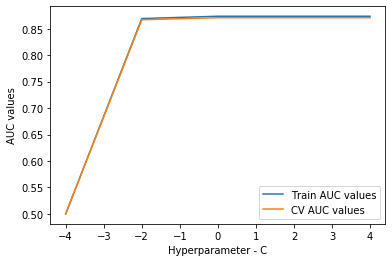

In [95]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')

clf_tfidfw2v_l1 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100,return_train_score=True)
clf_tfidfw2v_l1.fit(tfidf_sent_vectors_train,y_train2)

print('AUC score for Logistic Regression Model with TFIDF W2V features and l1 regularization ',clf_tfidfw2v_l1.cv_results_['mean_train_score'])

AUC_tfidfw2v_train_l1 = clf_tfidfw2v_l1.cv_results_['mean_train_score']
best_auc_score_tfidfw2v_l1 = clf_tfidfw2v_l1.best_score_
optimal_C_tfidfw2v_l1 = clf_tfidfw2v_l1.best_params_['C']

print('best_auc_score_tfidfw2v_l1 ',best_auc_score_tfidfw2v_l1)
print('optimal_C_tfidfw2v_l1 ',optimal_C_tfidfw2v_l1)

#finding auc scores for our CV data for validation
AUC_tfidfw2v_CV_l1 = clf_tfidfw2v_l1.cv_results_['mean_test_score']
    

#plotting ROC curve for train and CV data
plt.plot(np.log10(hyperparameters['C']),AUC_tfidfw2v_train_l1,label='Train AUC values')
plt.plot(np.log10(hyperparameters['C']),AUC_tfidfw2v_CV_l1,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

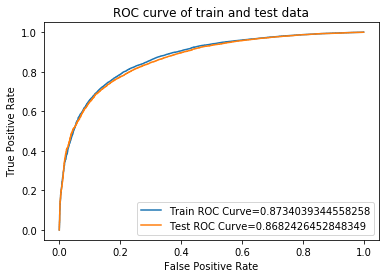

In [96]:
#Plotting ROC curve as FPR vs TPR

model_roc_l1 = LogisticRegression(penalty='l1',solver='liblinear',C=optimal_C_tfidfw2v_l1,class_weight='balanced')
model_roc_l1 = model_roc_l1.fit(tfidf_sent_vectors_train,y_train2)

y_pred_train_l1 = model_roc_l1.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr1,tpr1,t1 = metrics.roc_curve(y_train2,y_pred_train_l1)

y_pred_test_l1 = model_roc_l1.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test,y_pred_test_l1)

plt.plot(fpr1,tpr1,label='Train ROC Curve=' +str(metrics.auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.6307020666781992 for threshold 0.475
*********Train confusion matrix*********
[[ 5037  1323]
 [ 7463 29185]]


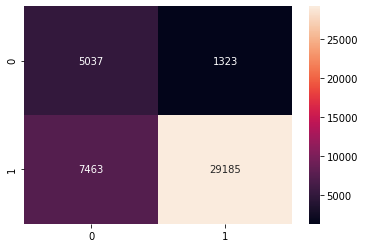

In [97]:
best_t_tfw2v_l1 = find_best_threshold(t1,fpr1,tpr1)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l1, best_t_tfw2v_l1)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l1, best_t_tfw2v_l1))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 3619   937]
 [ 4840 16936]]


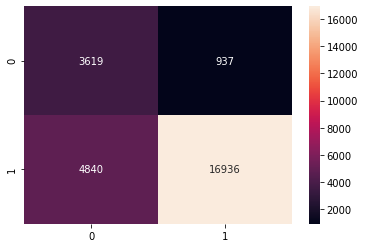

In [98]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_test_l1, best_t_tfw2v_l1)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_test_l1, best_t_tfw2v_l1))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

In [99]:

##Calculating sparsity on weight vector obtained using L1 regularization on AVG W2V
#using already trained model

coef_tfidfw2v_l1 = model_roc_l1.coef_.ravel()
sparsity_tfidf2v_l1 = np.mean(coef_tfidfw2v_l1 == 0) * 100

print('sparsity_tfidf2v_l1 ',sparsity_tfidf2v_l1)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(model_roc_l1.coef_))

sparsity_tfidf2v_l1  0.0
Number of non zero entries which indicates sparsity  50


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

AUC score for Logistic Regression Model with TFIDF W2V features and l2 regularization  [0.85169548 0.87213248 0.87352902 0.87353148 0.87353143]
best_auc_score_tfidfw2v_l2  0.8707681835680982
optimal_C_tfidfw2v_l2  1


Text(0, 0.5, 'AUC values')

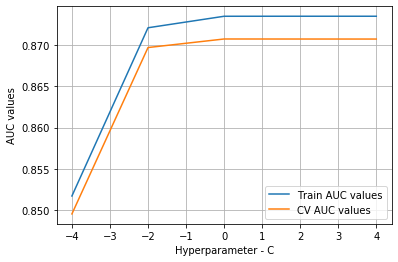

In [100]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l2',class_weight='balanced')

clf_tfidfw2v_l2 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100,return_train_score=True)
clf_tfidfw2v_l2.fit(tfidf_sent_vectors_train,y_train2)

print('AUC score for Logistic Regression Model with TFIDF W2V features and l2 regularization ',clf_tfidfw2v_l2.cv_results_['mean_train_score'])

AUC_tfidfw2v_train_l2 = clf_tfidfw2v_l2.cv_results_['mean_train_score']
best_auc_score_tfidfw2v_l2 = clf_tfidfw2v_l2.best_score_
optimal_C_tfidfw2v_l2 = clf_tfidfw2v_l2.best_params_['C']

print('best_auc_score_tfidfw2v_l2 ',best_auc_score_tfidfw2v_l2)
print('optimal_C_tfidfw2v_l2 ',optimal_C_tfidfw2v_l2)

#finding auc scores for our CV data for validation
AUC_tfidfw2v_CV_l2 = clf_tfidfw2v_l2.cv_results_['mean_test_score']
    

#plotting ROC curve for train and CV data
plt.plot(np.log10(hyperparameters['C']),AUC_tfidfw2v_train_l2,label='Train AUC values')
plt.plot(np.log10(hyperparameters['C']),AUC_tfidfw2v_CV_l2,label='CV AUC values')
plt.legend()
plt.grid()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l2  


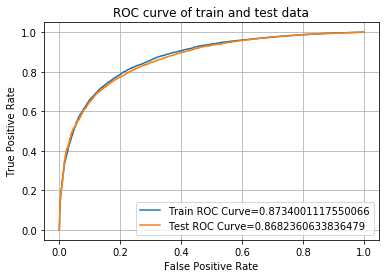

In [101]:
#Plotting ROC curve as FPR vs TPR

model_roc_l2 = LogisticRegression(penalty='l2',C=optimal_C_tfidfw2v_l2,class_weight='balanced')
model_roc_l2 = model_roc_l2.fit(tfidf_sent_vectors_train,y_train2)

y_pred_train_l2 = model_roc_l2.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr1,tpr1,t1 = metrics.roc_curve(y_train2,y_pred_train_l2)

y_pred_test_l2 = model_roc_l2.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test,y_pred_test_l2)

plt.plot(fpr1,tpr1,label='Train ROC Curve=' +str(metrics.auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()



the maximum value of tpr*(1-fpr) 0.6309785839514868 for threshold 0.475
*********Train confusion matrix*********
[[ 5038  1322]
 [ 7456 29192]]


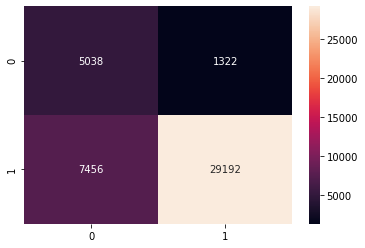

In [102]:
best_t_tfw2v_l2 = find_best_threshold(t1,fpr1,tpr1)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l2, best_t_tfw2v_l2)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(y_pred_train_l2, best_t_tfw2v_l2))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 3619   937]
 [ 4840 16936]]


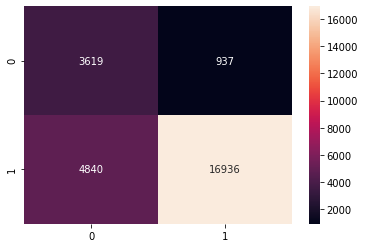

In [103]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(y_pred_test_l2, best_t_tfw2v_l2)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_pred_test_l2, best_t_tfw2v_l2))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

In [104]:

##Calculating sparsity on weight vector obtained using l2 regularization on AVG W2V
#using already trained model

coef_tfidfw2v_l2 = model_roc_l2.coef_.ravel()
sparsity_tfidf2v_l2 = np.mean(coef_tfidfw2v_l2 == 0) * 100

print('sparsity_tfidf2v_l2 ',sparsity_tfidf2v_l2)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(model_roc_l2.coef_))

sparsity_tfidf2v_l2  0.0
Number of non zero entries which indicates sparsity  50


# [6] Conclusions

In [105]:
# Please compare all your models using Prettytable library
print('Number of data points used : 100k\n')
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Regularization", "Hyperameter(lambda)", "AUC",'sparsity']
x.add_row(["BOW","l1",optimal_C_bow_l1,best_auc_score_bow_l1,sparsity_bow_l1])
x.add_row(["BOW","l2",optimal_C_bow_l2,best_auc_score_bow_l2,sparsity_bow_l2])
x.add_row(["TFIDF","l1",optimal_C_tfidf_l1,best_auc_score_tfidf_l1,sparsity_tfidf_l1])
x.add_row(["TFIDF","l2",optimal_C_tfidf_l2,best_auc_score_tfidf_l2,sparsity_tfidf_l2])
x.add_row(["Avg W2v","l1",optimal_C_avgw2v_l1,best_auc_score_avgw2v_l1,'N/A'])
x.add_row(["Avg W2v","l2",optimal_C_avgw2v_l2,best_auc_score_avgw2v_l2,'N/A'])
x.add_row(["TFIDF Avg W2v",'l1',optimal_C_tfidfw2v_l1,best_auc_score_tfidfw2v_l1,'N/A'])
x.add_row(["TFIDF Avg W2v","l2",optimal_C_tfidfw2v_l2,best_auc_score_tfidfw2v_l2,'N/A'])
print(x)

Number of data points used : 100k

+---------------+----------------+---------------------+--------------------+-------------------+
|   Vectorizer  | Regularization | Hyperameter(lambda) |        AUC         |      sparsity     |
+---------------+----------------+---------------------+--------------------+-------------------+
|      BOW      |       l1       |          1          | 0.919703726203928  | 89.14776685501974 |
|      BOW      |       l2       |         0.01        | 0.9261930805224466 |        0.0        |
|     TFIDF     |       l1       |          1          | 0.948897972639003  |  93.2267316229914 |
|     TFIDF     |       l2       |          1          | 0.9558950377524006 |        0.0        |
|    Avg W2v    |       l1       |          1          | 0.8940469734684754 |        N/A        |
|    Avg W2v    |       l2       |          1          | 0.8944570785532276 |        N/A        |
| TFIDF Avg W2v |       l1       |          1          | 0.8707662115672227 |      